In [130]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import re

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('whitegrid')

np.random.seed(2016)

In [131]:
# load files
train = pd.read_csv('../data/train2016.csv')
test  = pd.read_csv('../data/test2016.csv')
sub   = pd.read_csv('../data/sampleSubmission2016.csv')

In [132]:
# concat training and test 
data = pd.concat((train, test))

In [133]:
data.isnull().sum().sort_values(ascending=False)

Q124742            4340
Q124122            3114
Q123621            3018
Q118232            3018
Q108855            3008
Q108856            3007
Q101163            2995
Q98078             2945
Q123464            2912
Q98869             2906
Q116881            2889
Q105840            2876
Q106389            2871
Q99982             2871
Q98578             2867
Q102674            2864
Q115390            2860
Q96024             2858
Q116953            2848
Q117186            2845
Q102906            2840
Q98197             2836
Q114152            2829
Q101596            2824
Q112270            2820
Q106388            2818
Q101162            2816
Q117193            2799
Q100562            2793
Q102289            2790
                   ... 
Q120014            2571
Q100689            2568
Q114517            2567
Q111220            2563
Q122120            2552
Q113992            2502
Q110740            2479
Q119334            2477
Q114748            2462
Q111848            2449
Q115611         

** Gender -> YOB -> HouseholdStatus -> EducationLevel -> Income**

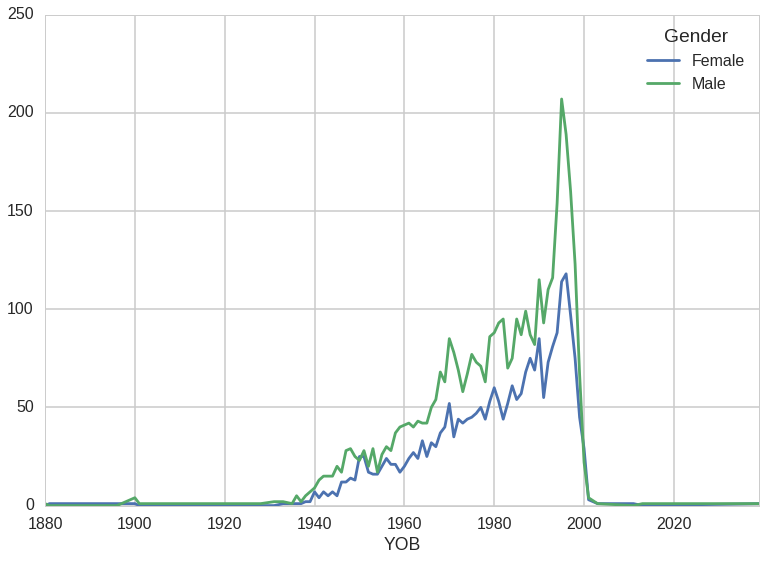

In [109]:
# let's see if gender and yob are in way related or not
data.groupby(['Gender', 'YOB']).size().unstack(0).fillna(0).plot();

In [134]:
# let's first impute missing values for gender
data['Gender'] = data.Gender.fillna('-9999')

In [135]:
# let's create new variable called 2016
data['Age'] = 2016 - data['YOB']

In [136]:
# drop YOB
data = data.drop('YOB', axis=1)

In [137]:
edu_age_map = data.groupby(['EducationLevel'])['Age'].apply(lambda x: np.median(x[x.notnull()])).to_dict()

def fill_age(df):
    if pd.isnull(df['Age']) or df['Age'] < 18 or df['Age'] > 80:
        if pd.isnull(df['EducationLevel']):
            return -9999
        else:
            return edu_age_map[df['EducationLevel']]
    else:
        return df['Age']
    
data['Age'] = data[['Age', 'EducationLevel']].apply(fill_age, axis=1)

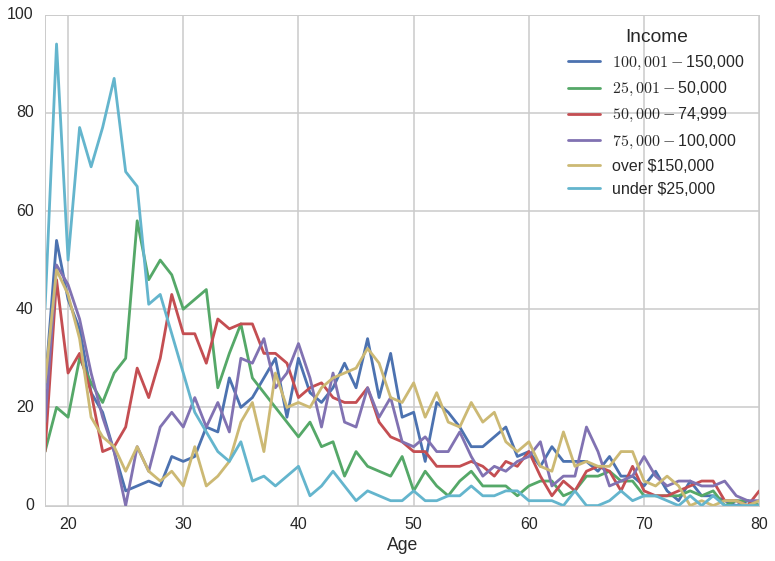

In [120]:
data[data.Age > 0].groupby(['Age', 'Income']).size().unstack().fillna(0).plot();

In [138]:
income_by_age = data.groupby(['Age'])['Income'].apply(lambda x: x.value_counts().index.values[0]).to_dict()

In [139]:
def fill_income(df):
    if pd.isnull(df['Income']):
        return income_by_age[df['Age']]
    else:
        return df['Income']
    
data['Income'] = data[['Age', 'Income']].apply(fill_income, axis=1)

In [140]:
data['EducationLevel']  = data['EducationLevel'].fillna(-9999)
data['HouseholdStatus'] = data['HouseholdStatus'].fillna(-9999)

In [148]:
data[data.columns[5:-2]].apply(lambda x: ','.join(list(x[x.notnull()].unique())))

Q100010                     Yes,No
Q100562                     No,Yes
Q100680                     No,Yes
Q100689                     Yes,No
Q101162         Optimist,Pessimist
Q101163                    Mom,Dad
Q101596                     Yes,No
Q102089                   Own,Rent
Q102289                     No,Yes
Q102674                     No,Yes
Q102687                     Yes,No
Q102906                     No,Yes
Q103293                     No,Yes
Q104996                     Yes,No
Q105655                     No,Yes
Q105840                     Yes,No
Q106042                     Yes,No
Q106272                     Yes,No
Q106388                     No,Yes
Q106389                     Yes,No
Q106993                     Yes,No
Q106997    Yay people!,Grrr people
Q107491                     No,Yes
Q107869                     Yes,No
Q108342           In-person,Online
Q108343                     No,Yes
Q108617                     No,Yes
Q108754                     No,Yes
Q108855             

In [149]:
yes_no_columns = [cat for cat in data.columns if 'Yes' in data[cat].unique()]

/home/abhishek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [159]:
def res_count(df):
    
    seq_yes = 0
    seq_no  = 0
    seq_missing = 0
    
    for feat in df.values:
        if feat == 'Yes':
            seq_yes += 1
        elif feat == 'No':
            seq_no += 1
        else:
            seq_missing += 1
    
    return seq_yes, seq_no, seq_missing
            
res_summary = data[yes_no_columns].apply(res_count, axis=1)

In [161]:
yes_count, no_count, missing_count = zip(*res_summary)

In [165]:
data['yes_count']     = yes_count
data['no_count']      = no_count
data['missing_count'] = missing_count

In [182]:
def res_seq(df):
    
    seq = ''
    
    for feat in df.values:
        if feat == 'Yes':
            seq += '1'
        elif feat == 'No':
            seq += '0'
        else:
            seq += '2'
    
    return seq

res_seq = data[yes_no_columns].apply(res_seq, axis=1)

In [199]:
three_nos = pd.Series(list(map(lambda x: len(re.findall(r'00000', x)), res_seq.values)))

In [200]:
pd.crosstab(three_nos, data.loc[data.Party.notnull(), 'Party'])

Party,Democrat,Republican
row_0,,
0,1791,1509
1,686,647
2,308,298
3,126,123
4,32,32
5,8,4
6,0,3
7,0,1


In [190]:
len(re.findall(r'000', res_seq.iloc[0]))

5

In [168]:
data_sub = data.loc[data.Party.notnull(), ['yes_count', 'no_count', 'missing_count', 'Party']]

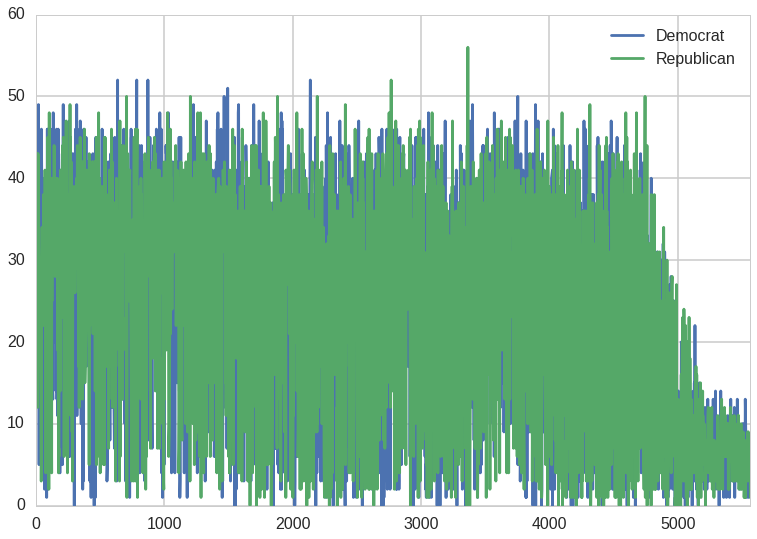

In [179]:
data_sub[data_sub.Party == 'Democrat']['yes_count'].plot(label='Democrat')
data_sub[data_sub.Party == 'Republican']['yes_count'].plot(label='Republican')
plt.legend(loc='best');

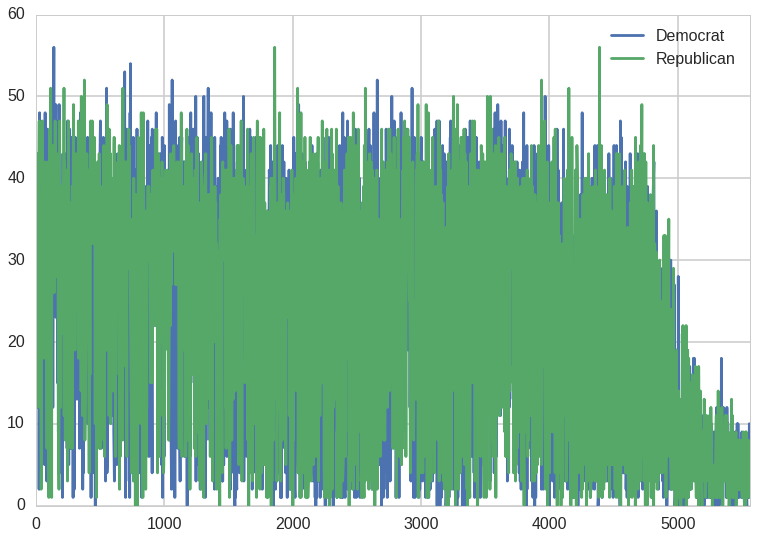

In [180]:
data_sub[data_sub.Party == 'Democrat']['no_count'].plot(label='Democrat')
data_sub[data_sub.Party == 'Republican']['no_count'].plot(label='Republican')
plt.legend(loc='best');

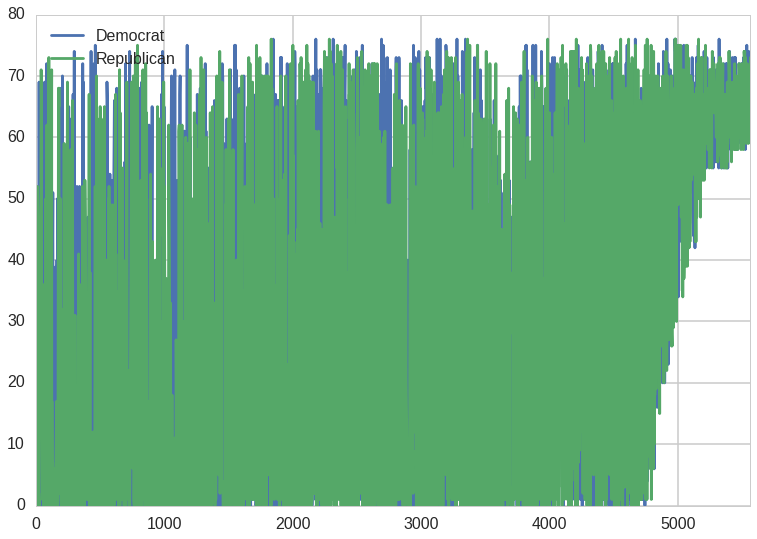

In [181]:
data_sub[data_sub.Party == 'Democrat']['missing_count'].plot(label='Democrat')
data_sub[data_sub.Party == 'Republican']['missing_count'].plot(label='Republican')
plt.legend(loc='best');

In [129]:
# save it to disk
data.to_csv('../data/imputed_data.csv', index=False)